In [1]:
import tensorflow as tf

2023-08-09 10:49:40.672349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 10:49:41.585635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [6]:
!nvidia-smi

Wed Aug  9 10:50:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   31C    P0    35W / 250W |    556MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
import random
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter



In [5]:
x_dir  = '../ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_1.npy'
x = np.load(x_dir)
x = x/np.amax(x)

y_dir  = '../ms_proj_shape_lc_gen/data_npy/shape_concat_npy/shape_concat1.npy'

y = np.load(y_dir)
print(np.amax(y))

# Normalizing the image of the shape
# y = y/255.0
where_0 = np.where(y == 0)
where_1 = np.where(y == 1)
y[where_0] = 1  # 1 represent the shape
y[where_1] = 0  # 0 represent background

1.0


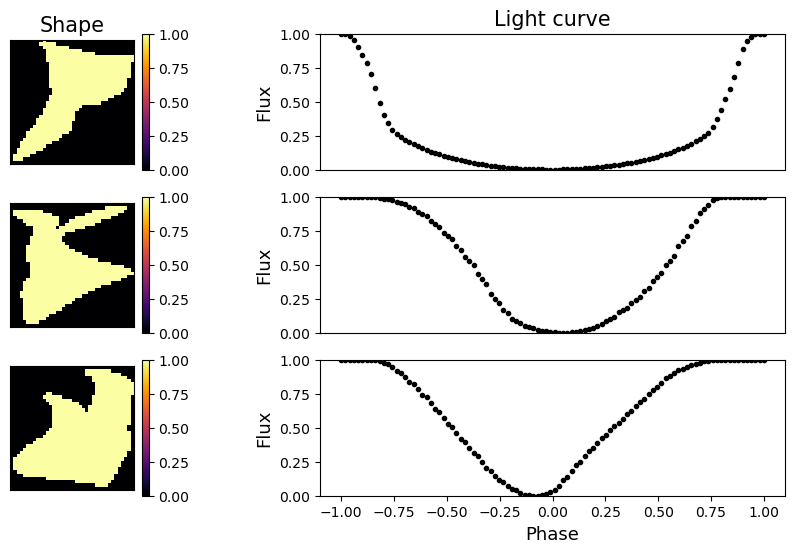

In [7]:
# Normalize light curve

x_scaled = np.zeros(x.shape)
for i in np.arange(len(x_scaled)):
    # x_scaled[i] = x[i] / np.linalg.norm(x[i])
    x_scaled[i] = (x[i] - np.amin(x[i]))/(np.amax(x[i]) - np.amin(x[i]))

# Plot some sample
np.random.seed(123)

num = 3
fig,ax=plt.subplots(num,2, figsize=(10,6), gridspec_kw={ 'width_ratios': [1,3],
        'wspace': 0.5,'hspace': 0.2})

ax[0][0].set_title('Shape',size=15)
ax[0][1].set_title('Light curve',size=15)
ax[num-1][1].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(x[0]))
for i in range(num):
    k = random.randint(0, len(x_scaled)-1)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][1].tick_params(labelbottom = False, bottom = False)
    img = ax[i][0].imshow(y[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][1].set_ylabel('Flux',size=13)
    ax[i][1].scatter(ph, x_scaled[k],color = 'black',marker='.')
    ax[i][1].set_ylim(0,1)

In [9]:
filenames = ['/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00000-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00001-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00002-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00003-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00004-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00005-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00006-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00007-of-00008']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [10]:
feature_description = {
    'global_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'local_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'av_training_set': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [11]:
# At this point the dataset contains serialized tf.train.Example messages.
# When iterated over it returns these as scalar string tensors.
# Use the .take method to only show the first 10 records.
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xdbG\n\x15\n\x0ctce_plnt_num\x12\x05\x1a\x03\n\x01\x02\n\x19\n\x0fav_training_set\x12\x06\n\x04\n\x02PC\n\x1b\n\x0ftce_max_mult_ev\x12\x08\x12\x06\n\x04H\xe1\x06B\n\x1a\n\x0espline_bkspace\x12\x08\x12\x06\n\x04\x9a\xa97@\n\x17\n\rav_pred_class\x12\x06\n\x04\n\x02PC\n\x15\n\ttce_depth\x12\x08\x12\x06\n\x043\x13PD\n\x16\n\ntce_impact\x12\x08\x12\x06\n\x04\x94\xf66?\n\x19\n\rtce_model_snr\x12\x08\x12\x06\n\x04\x14\xae\x02B\n\x14\n\x08tce_prad\x12\x08\x12\x06\n\x04\xecQ@@\n\x17\n\x0btce_time0bk\x12\x08\x12\x06\n\x04\x17\x193C\n\xda>\n\x0bglobal_view\x12\xca>\x12\xc7>\n\xc4>\x8a\x99\xbc<\xde\x8f\x9c\xbdl\xf5l<(s\r=o\x1f\xe8\xba\t\xcf\xbd\xbcG\n\xc2\xbc"\x1f\x17\xbc\xfd&\xd1\xbc\x15w*=f\xa1v\xbc\xea\x95\xf0\xbci\xcb\xf1<\x00\x00\x00\x00g6t\xbd\x1f\xf5\x9b=\xabg\x87<]\xc5\x1d=.\xc7\x83<\\0\xa0\xbd\xb0&\x00>\x98\xd6\xa6<\x96A)\xbcb\x84\x96\xbd\xb6)\xaa\xbd)\x08\x8b\xbc\x1c\x1cm>\xab\x16\xbb=}\\R=\xf3\x13b\xbc\x02\xe6\xc9\xbdg6t\xbd\x93\x17\xae\xbc

2023-08-07 19:08:32.842711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]


In [12]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<_MapDataset element_spec={'av_training_set': TensorSpec(shape=(), dtype=tf.string, name=None), 'global_view': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'local_view': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>

In [13]:
y = np.array([])
for elem in parsed_dataset.take(1):
  y = np.append(y,[elem['local_view']])
length_lc = len(y)
print("length_lc = " ,length_lc)

no_data = 0
for elem in parsed_dataset.as_numpy_iterator():
    no_data = no_data + 1
print('no_data = ',no_data)

lc_np_array = np.zeros(shape=(no_data,length_lc))
lc_np_array.shape


i = 0
for elem in parsed_dataset.as_numpy_iterator():
    lc_np_array[i] = elem['local_view']
    i = i + 1

print(lc_np_array[0])

2023-08-07 19:08:42.628344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]
2023-08-07 19:08:42.658802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]


length_lc =  201
no_data =  12589
[-6.92397356e-02 -2.56392676e-02 -4.75080535e-02 -6.34126291e-02
 -2.86556520e-02 -7.22561181e-02 -7.22561181e-02  1.56303551e-02
  3.60595062e-02  5.99163622e-02  5.51175699e-02 -4.38746847e-02
  6.16987748e-03  4.48344424e-02  2.11146921e-02  1.93322822e-02
  4.11325163e-04 -4.53828759e-02 -5.10728732e-02 -5.02502210e-02
 -3.57852876e-02 -9.18626133e-03  3.29060107e-02  5.47062457e-02
 -7.54096126e-03  1.37108378e-04  2.26228833e-02  2.57763769e-02
  1.12977311e-01  9.85809267e-02  7.41756335e-02  3.29060107e-02
 -7.87687674e-02  2.42681839e-02  1.53561393e-02  8.08939431e-03
 -1.70014389e-02 -8.80235806e-02 -7.41756335e-02 -7.97970816e-02
 -5.81339560e-02 -2.64619179e-02 -3.08493860e-02  2.33084261e-02
 -3.53739634e-02 -3.53739634e-02  1.37108390e-03  1.09686712e-02
 -1.68643314e-02  1.72756556e-02  1.87838487e-02  1.87838487e-02
  2.60505918e-03  6.95139542e-02 -4.53828759e-02 -6.64975643e-02
  6.71831099e-03 -4.66168523e-02 -2.87927613e-02 -5.5391

In [14]:
lc_label_array = np.chararray(shape=(no_data,))

i = 0
for elem in parsed_dataset.as_numpy_iterator():
    lc_label_array[i] = elem['av_training_set']
    i = i + 1

index_label_P = np.where(lc_label_array==b'P')
print(index_label_P)
print(lc_label_array[index_label_P])

no_of_Plabel = len(index_label_P[0])
print('no_of_Plabel = ',no_of_Plabel)

(array([    0,     3,     4, ..., 12586, 12587, 12588]),)
[b'P' b'P' b'P' ... b'P' b'P' b'P']
no_of_Plabel =  2885


index_noise =  (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]),)


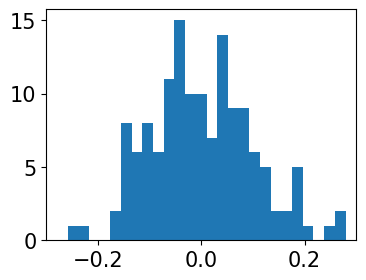

In [15]:
fig = plt.figure(figsize = (4,3))
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.dpi': '100'})

x = np.linspace(-1,1,len(lc_np_array[0]))
# index_noise = np.where((x<-0.25) | (x>0.25))
index_noise = np.where((x<-0.3) | (x>0.3))
print('index_noise = ',index_noise)

bin_hist = np.linspace(-0.3,0.3,30)
plt.hist(lc_np_array[3][index_noise],bins = bin_hist)
plt.xlim(-0.3,0.3)
plt.show()


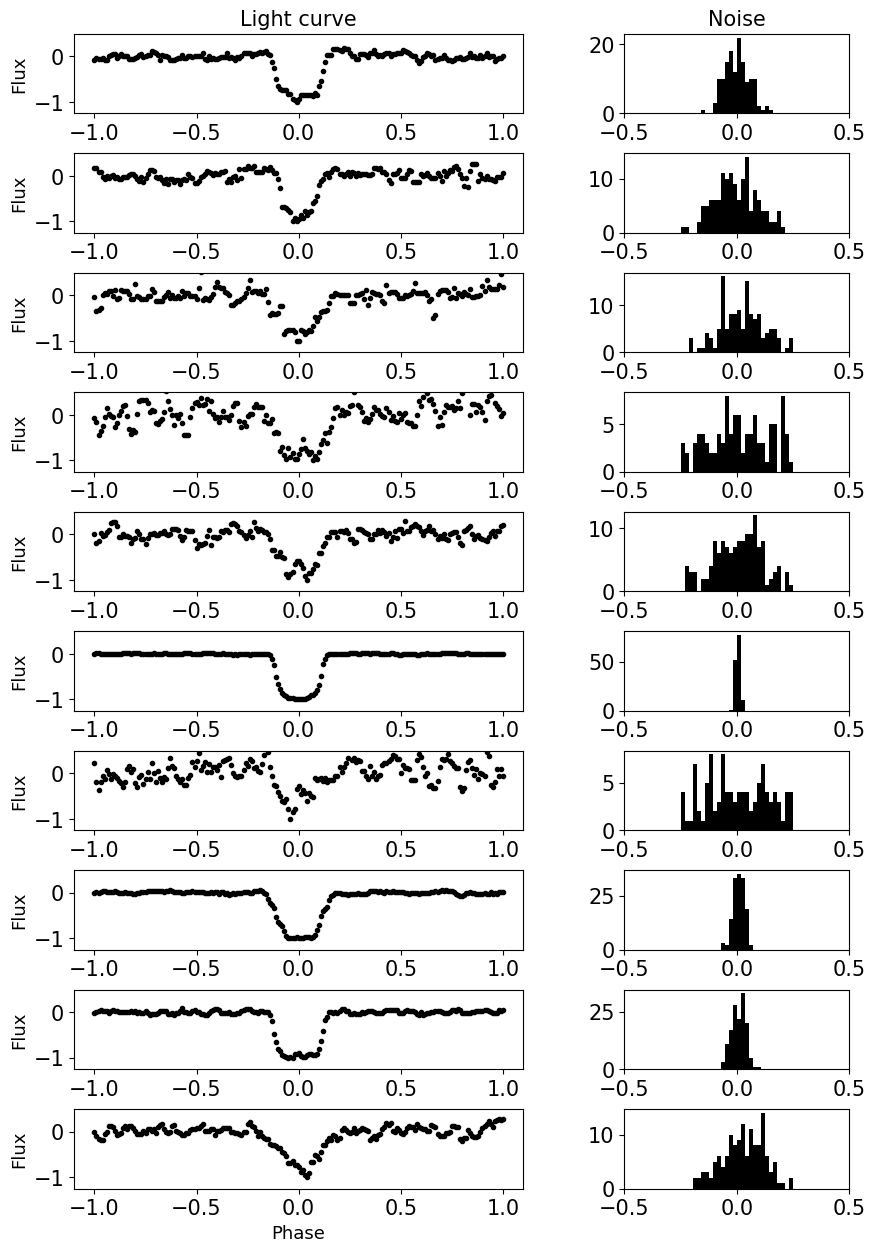

In [16]:
# Plot noise in Kepler data
num = 10

# Binning edges
bin_hist = np.linspace(-0.25,0.25,29)


fig,ax=plt.subplots(num,2, figsize=(10,15), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.3,'hspace': 0.5})

ax[0][1].set_title('Noise',size=15)
ax[0][0].set_title('Light curve',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(lc_np_array[0]))
for i in range(num):
    k = index_label_P[0][i] # random.choice(index_label_P[0]) # random.randint(0, len(lc_np_array[0])-1)
    ax[i][1].hist(lc_np_array[k][index_noise],bins=bin_hist,color='black')
    ax[i][1].set_xlim(-0.5,0.5)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].scatter(ph, lc_np_array[k],color = 'black',marker='.')
    ax[i][0].set_ylim(-1.25,0.5)

In [ ]:
#

In [89]:
# Adding noise

x_scaled_noise = np.zeros(x_scaled.shape)
print('x_scaled_noise.shape = ',x_scaled_noise.shape)

noise_mean_array = np.abs(np.loadtxt('mean_noise.csv'))
print('noise_mean_array = ',noise_mean_array.shape)

noise_sigma_array = np.abs(np.loadtxt('sigma_noise.csv'))
print('noise_sigma_array = ',noise_sigma_array.shape)

s = np.zeros(x_scaled.shape)
used_mean = np.zeros(x_scaled.shape[0])
used_sigma = np.zeros(x_scaled.shape[0])

print('s = ',s.shape)
print('int(x_scaled.shape[0]) = ',int(x_scaled.shape[0]))

for i in np.arange(0,int(x_scaled.shape[0]),1):
    print('i = ',i)
    k = random.randint(0, len(noise_mean_array)-1)
    print('k =',k)
    # s[i] = np.random.normal(noise_mean_array[k], noise_sigma_array[k], len(x_scaled[0]))
    s[i] = np.random.normal(0, noise_sigma_array[k], len(x_scaled[0]))
    used_mean[i] = 0 # noise_mean_array[k]
    used_sigma[i] = noise_sigma_array[k]

x_scaled_noise = x_scaled + s

x_scaled_noise.shape =  (20000, 100)
noise_mean_array =  (2885,)
noise_sigma_array =  (2885,)
s =  (20000, 100)
int(x_scaled.shape[0]) =  20000
i =  0
k = 2205
i =  1
k = 526
i =  2
k = 1205
i =  3
k = 465
i =  4
k = 2137
i =  5
k = 859
i =  6
k = 1920
i =  7
k = 1980
i =  8
k = 2720
i =  9
k = 72
i =  10
k = 2685
i =  11
k = 983
i =  12
k = 1813
i =  13
k = 96
i =  14
k = 672
i =  15
k = 218
i =  16
k = 1301
i =  17
k = 2326
i =  18
k = 1317
i =  19
k = 2427
i =  20
k = 323
i =  21
k = 1976
i =  22
k = 2292
i =  23
k = 1198
i =  24
k = 1186
i =  25
k = 1307
i =  26
k = 6
i =  27
k = 216
i =  28
k = 1279
i =  29
k = 357
i =  30
k = 1417
i =  31
k = 511
i =  32
k = 1138
i =  33
k = 725
i =  34
k = 1001
i =  35
k = 2503
i =  36
k = 883
i =  37
k = 2395
i =  38
k = 2883
i =  39
k = 2724
i =  40
k = 933
i =  41
k = 1355
i =  42
k = 1470
i =  43
k = 2494
i =  44
k = 1079
i =  45
k = 925
i =  46
k = 593
i =  47
k = 290
i =  48
k = 2408
i =  49
k = 1478
i =  50
k = 2709
i =  51
k = 1514
i =  

In [90]:
print(noise_mean_array.shape)
print(used_mean.shape)

(2885,)
(20000,)


Text(0, 0.5, 'Mean from original distribution')

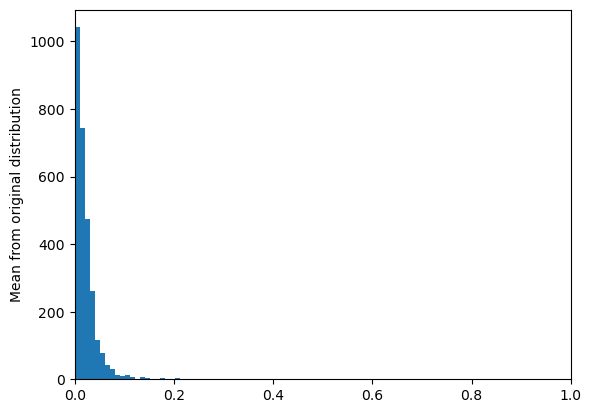

In [91]:
bins = np.linspace(0,1,100)
plt.hist(noise_mean_array,bins=bins)
plt.xlim(0,1)
plt.ylabel('Mean from original distribution')

Text(0.5, 1.0, "Distribution of Sigma from Shallue's Kepler Dataset")

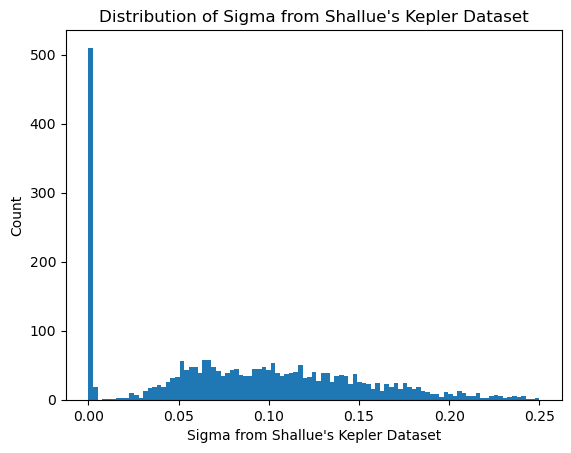

In [110]:
bins = np.linspace(0,0.25,100)
plt.hist(noise_sigma_array,bins=bins)
plt.ylabel('Count')
plt.xlabel('Sigma from Shallue\'s Kepler Dataset')
plt.title('Distribution of Sigma from Shallue\'s Kepler Dataset')

In [93]:
used_mean.shape

(20000,)

Text(0, 0.5, 'Mean from noise added simulated light curve')

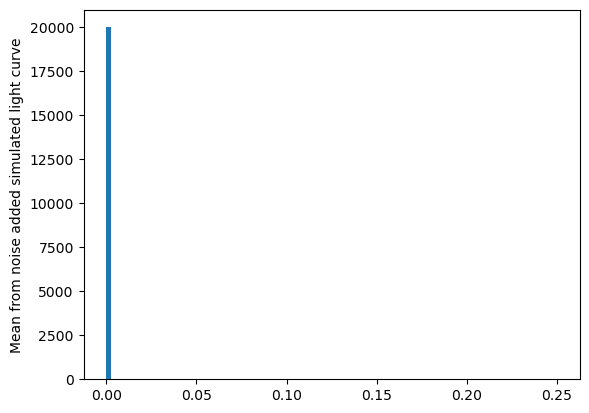

In [94]:
bins = np.linspace(0,0.25,100)
plt.hist(used_mean,bins=bins)
plt.ylabel('Mean from noise added simulated light curve')

Text(0.5, 1.0, 'Distribution of standard deviation (sigma) for the noise added light curves')

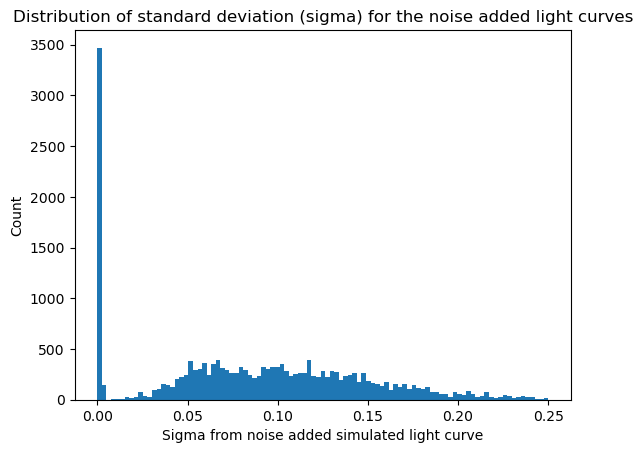

In [107]:
bins = np.linspace(0,0.25,100)
plt.hist(used_sigma,bins=bins)
plt.ylabel('Count')
plt.xlabel('Sigma from noise added simulated light curve')
plt.title('Distribution of standard deviation (sigma) for the noise added light curves')

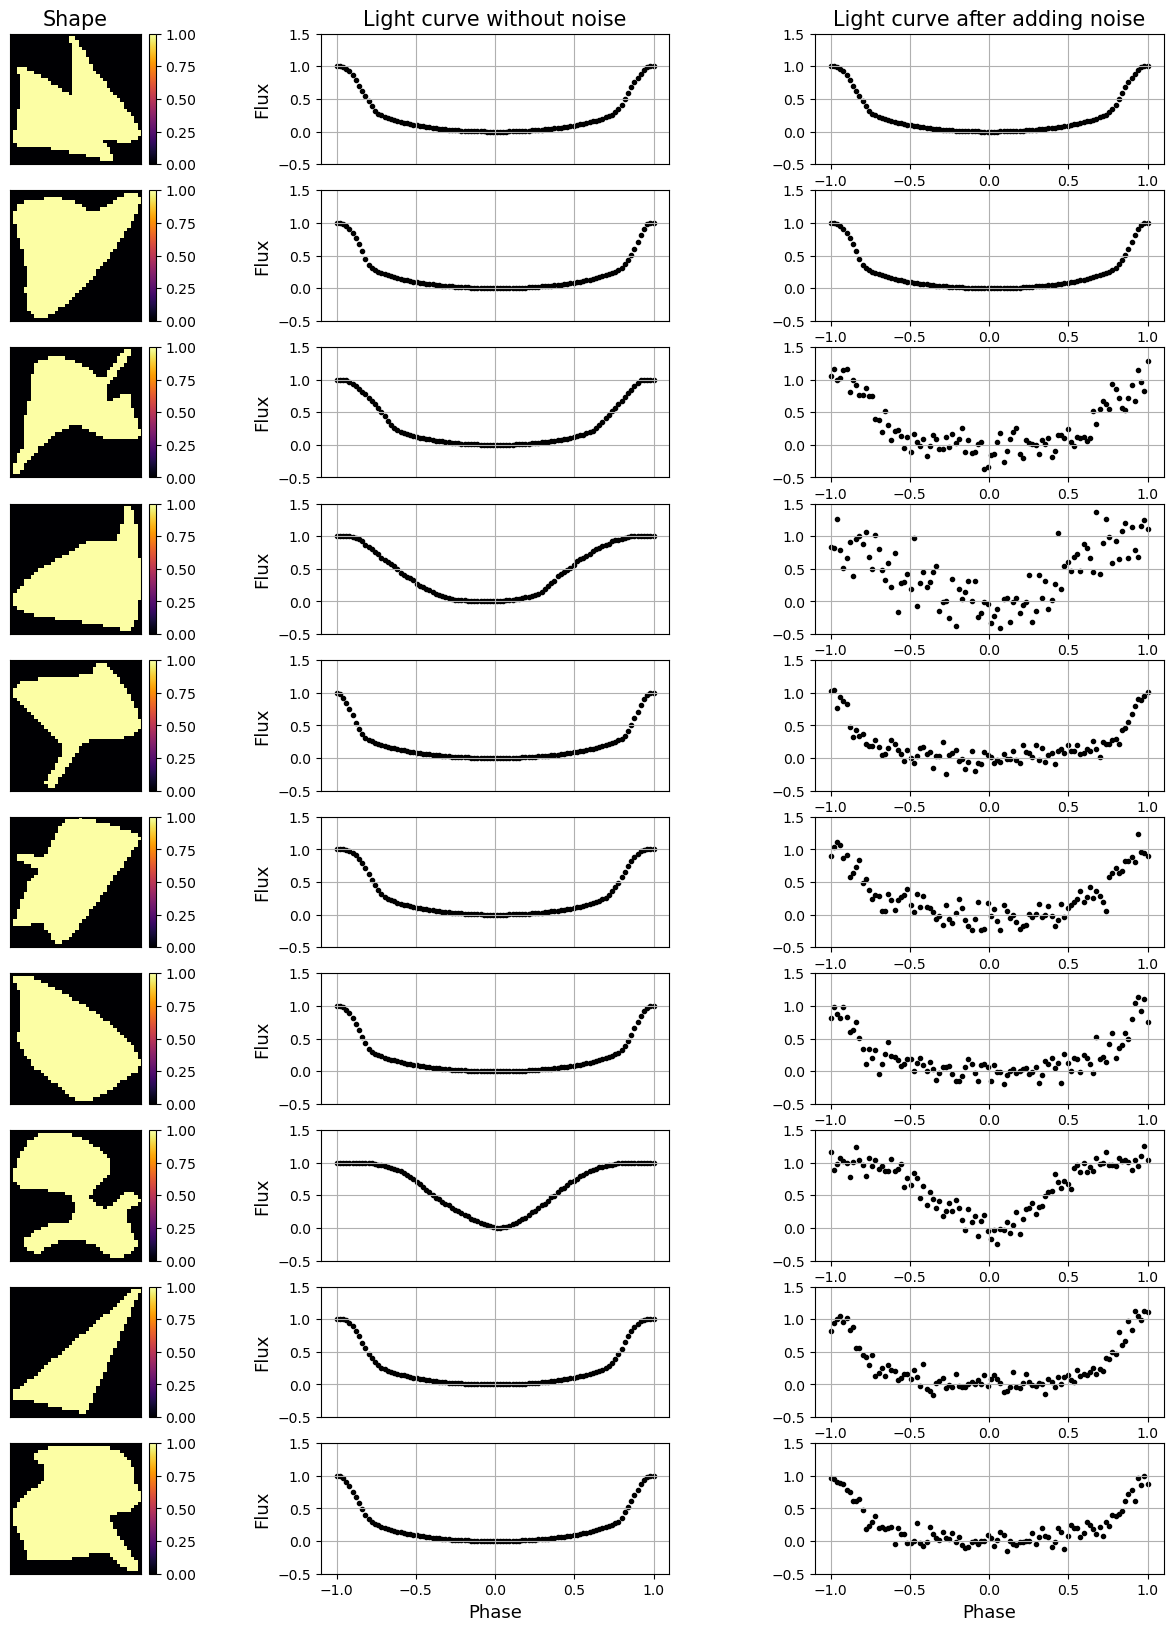

In [96]:
# Plot some sample
np.random.seed(123)


num = 10
fig,ax=plt.subplots(num,3, figsize=(15,20), gridspec_kw={ 'width_ratios': [1,2,2],
        'wspace': 0.5,'hspace': 0.2})

ax[0][0].set_title('Shape',size=15)
ax[0][1].set_title('Light curve without noise',size=15)
ax[num-1][1].set_xlabel('Phase',size=13)
ax[0][2].set_title('Light curve after adding noise',size=15)
ax[num-1][2].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(x_scaled[0]))

for i in range(num):
    k = random.randint(0, len(x_scaled)-1)

    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][1].tick_params(labelbottom = False, bottom = False)
    img = ax[i][0].imshow(y[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][1].set_ylabel('Flux',size=13)
    ax[i][1].scatter(ph, x_scaled[k],color = 'black',marker='.')
    ax[i][1].set_ylim(-0.5,1.5)
    ax[i][1].grid('on')
    ax[i][2].scatter(ph, x_scaled_noise[k],color = 'black',marker='.')
    ax[i][2].set_ylim(-0.5,1.5)
    ax[i][2].grid('on')

In [97]:
x_filtered = savgol_filter(x_scaled_noise,window_length = 40, polyorder = 2)
x_filtered.shape

(20000, 100)

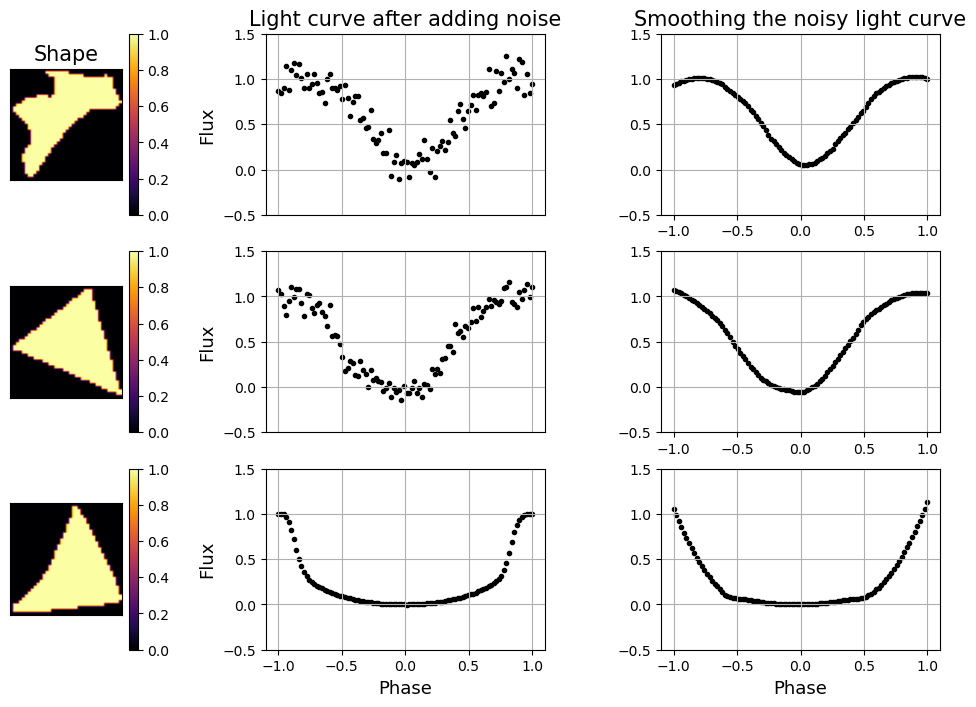

In [98]:
# Plot some sample
np.random.seed(123)


num = 3
fig,ax=plt.subplots(num,3, figsize=(12,8), gridspec_kw={ 'width_ratios': [1,2,2],
        'wspace': 0.5,'hspace': 0.2})

ax[0][0].set_title('Shape',size=15)
ax[0][1].set_title('Light curve after adding noise',size=15)
ax[num-1][1].set_xlabel('Phase',size=13)
ax[0][2].set_title('Smoothing the noisy light curve',size=15)
ax[num-1][2].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(x_scaled[0]))

for i in range(num):
    k = random.randint(0, len(x_scaled)-1)

    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][1].tick_params(labelbottom = False, bottom = False)
    img = ax[i][0].imshow(y[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][1].set_ylabel('Flux',size=13)
    ax[i][1].scatter(ph, x_scaled_noise[k],color = 'black',marker='.')
    ax[i][1].set_ylim(-0.5,1.5)
    ax[i][1].grid('on')
    ax[i][2].scatter(ph, x_filtered[k],color = 'black',marker='.')
    ax[i][2].set_ylim(-0.5,1.5)
    ax[i][2].grid('on')

In [99]:
# Splitting dataset into Train and Test (80 - 20)

x_ML = x_scaled_noise # x_filtered # x_scaled # x
y_ML = y

xTrain, xTest, yTrain, yTest = train_test_split(x_ML, y_ML, test_size=0.01, random_state=5)

print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

(19800, 100) (200, 100) (19800, 38, 38) (200, 38, 38)


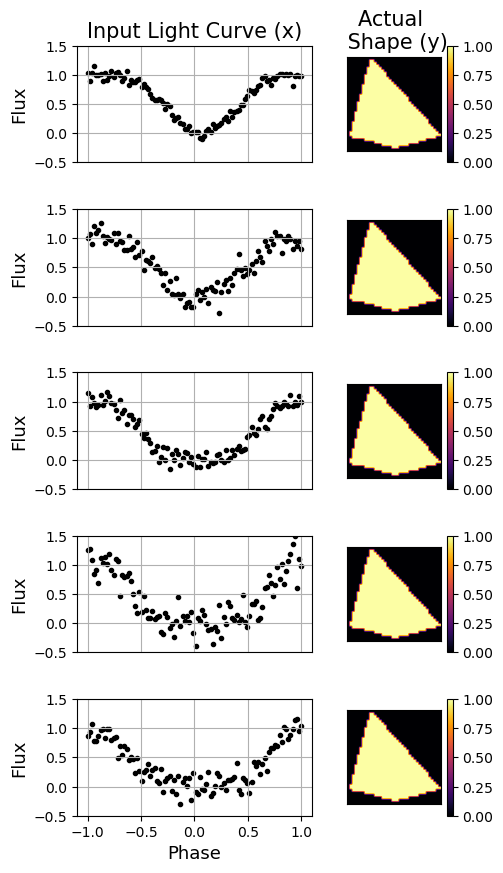

In [100]:
num = 5
fig,ax=plt.subplots(num,2, figsize=(5,10), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(x_ML[0]))
# advance = 60
num_array = [1,1001,2001,3001,4001]

i = 0
for i in np.arange(0,len(num_array)):
    k = num_array[i]
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(y_ML[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, x_ML[k],color = 'black',marker='.')
    ax[i][0].grid('on')
    i = i + 1

In [ ]:
# # Deep learning model (same as that used by Ushasi)
# input_shape = np.array(np.shape(x_ML[0]))
# print("np.shape(input_shape) = ",input_shape[0])

# output_shape = np.array(np.shape(y_ML[0]))
# print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

# START = input_shape[0] # 94 #
# END = output_shape[0] # 38  # pixel size along one axis
# print("Start = ",START)
# print("End = ",END)

# conv_ip = keras.layers.Input(shape=(START,),name='Input')
# x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
# x= keras.layers.BatchNormalization()(x)

# x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
# x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
# x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

# x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
# x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
# x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

# x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
# x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
# x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

# # x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='first_conv128_5', padding='same')(x)
# # x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='second_conv128_5', padding='same')(x)
# # x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_4', padding='same')(x) #100

# # x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='first_conv256_5', padding='same')(x)
# # x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='second_conv256_5', padding='same')(x)
# # x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_5', padding='same')(x) #100


# x=keras.layers.Flatten(name='flat_1')(x)

# # x2=keras.layers.Dense(512,name='dense_layer_1',activation='relu')(x)
# # x2=keras.layers.Dense(512,name='dense_layer_2',activation='relu')(x2)
# # x2=keras.layers.Dense(512,name='dense_layer_3',activation='relu')(x2)
# # x2=keras.layers.Dense(512,name='dense_layer_4',activation='relu')(x2)

# x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
# x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)
# # x2=keras.layers.Dense(256,name='dense_layer_7',activation='relu')(x2)
# # x2=keras.layers.Dense(256,name='dense_layer_8',activation='relu')(x2)

# x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
# x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

# x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
# x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
# x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
# x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
# conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
# model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
# model.summary()


In [101]:
# Deep learning model (same as that used by Ushasi)
input_shape = np.array(np.shape(x_ML[0]))
print("np.shape(input_shape) = ",input_shape[0])

output_shape = np.array(np.shape(y_ML[0]))
print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

START = input_shape[0] # 94 #
END = output_shape[0] # 38  # pixel size along one axis
print("Start = ",START)
print("End = ",END)

conv_ip = keras.layers.Input(shape=(START,),name='Input')
x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x= keras.layers.BatchNormalization()(x)

x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

# x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='first_conv128_5', padding='same')(x)
# x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='second_conv128_5', padding='same')(x)
# x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_4', padding='same')(x) #100

# x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='first_conv256_5', padding='same')(x)
# x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='second_conv256_5', padding='same')(x)
# x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_5', padding='same')(x) #100


x=keras.layers.Flatten(name='flat_1')(x)

# x2=keras.layers.Dense(512,name='dense_layer_1',activation='relu')(x)
# x2=keras.layers.Dense(512,name='dense_layer_2',activation='relu')(x2)
# x2=keras.layers.Dense(512,name='dense_layer_3',activation='relu')(x2)
# x2=keras.layers.Dense(512,name='dense_layer_4',activation='relu')(x2)

x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)
# x2=keras.layers.Dense(256,name='dense_layer_7',activation='relu')(x2)
# x2=keras.layers.Dense(256,name='dense_layer_8',activation='relu')(x2)

x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()


np.shape(input_shape) =  100
np.shape(input_shape) =  38 38
Start =  100
End =  38
Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 100, 1)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 100, 1)           4         
 hNormalization)                                                 
                                                                 
 conv16_5 (Conv1D)           (None, 100, 16)           96        
                                                                 
 second_conv16_5 (Conv1D)    (None, 100, 16)           1296      
                                                                 
 maxpool_1 (MaxPooling1D)   

In [102]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')


In [103]:
#Patience early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30,restore_best_weights=True)
# es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#Learning rate scheduler
# def step_decay(epoch):
# 	initial_lrate = 0.0001
# 	drop = 0.5
# 	epochs_drop = 50
# 	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
# 	return lrate

def step_decay(epoch):
    if epoch < 500:
        lrate = 0.00001
        return lrate
    else:
        lrate = 0.000001
        return lrate

lr_sched = keras.callbacks.LearningRateScheduler(step_decay)

In [ ]:
# Only for retraining from saved model
# model = load_model('/home/abraham/Documents/ml_test/ml_saved_models/aug7_v1/model_aug9_v1_2000epoch_noise_nofilter_lc.h5')


In [104]:
# Train the model

history = model.fit(xTrain, yTrain, epochs=2000,verbose=2, validation_split=0.2,callbacks=[es,lr_sched])

Epoch 1/2000
495/495 - 13s - loss: 0.3758 - val_loss: 0.5799 - lr: 1.0000e-05 - 13s/epoch - 26ms/step
Epoch 2/2000
495/495 - 8s - loss: 0.2242 - val_loss: 0.3875 - lr: 1.0000e-05 - 8s/epoch - 16ms/step
Epoch 3/2000
495/495 - 8s - loss: 0.1952 - val_loss: 0.3102 - lr: 1.0000e-05 - 8s/epoch - 15ms/step
Epoch 4/2000
495/495 - 7s - loss: 0.1837 - val_loss: 0.2543 - lr: 1.0000e-05 - 7s/epoch - 14ms/step
Epoch 5/2000
495/495 - 8s - loss: 0.1783 - val_loss: 0.2186 - lr: 1.0000e-05 - 8s/epoch - 16ms/step
Epoch 6/2000
495/495 - 8s - loss: 0.1746 - val_loss: 0.1881 - lr: 1.0000e-05 - 8s/epoch - 16ms/step
Epoch 7/2000
495/495 - 8s - loss: 0.1718 - val_loss: 0.1967 - lr: 1.0000e-05 - 8s/epoch - 16ms/step
Epoch 8/2000
495/495 - 7s - loss: 0.1704 - val_loss: 0.1736 - lr: 1.0000e-05 - 7s/epoch - 14ms/step
Epoch 9/2000
495/495 - 8s - loss: 0.1697 - val_loss: 0.1733 - lr: 1.0000e-05 - 8s/epoch - 16ms/step
Epoch 10/2000
495/495 - 8s - loss: 0.1694 - val_loss: 0.1736 - lr: 1.0000e-05 - 8s/epoch - 15ms/st

In [105]:
save_model(model, "/home/abraham/Documents/ml_test/ml_saved_models/aug9_v2/model_aug9_v2_2000epoch_noise_nofilter_lc.h5")

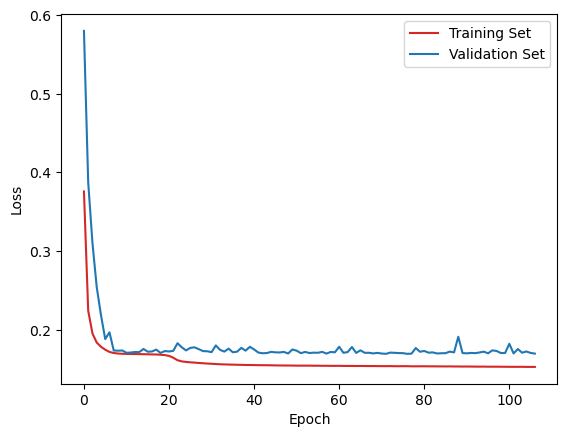

In [106]:
# Plot training parameters
plt.plot(history.history['loss'], label='Training Set',color = "tab:red")
plt.plot(history.history['val_loss'], label='Validation Set',color = "tab:blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

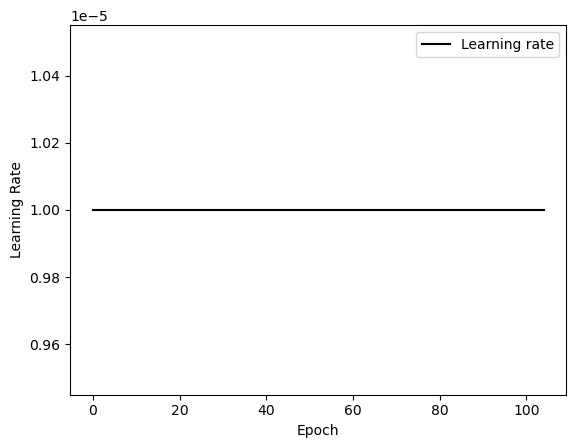

In [79]:
plt.plot(history.history['lr'], label='Learning rate',color = "black")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()

In [ ]:
pl-

In [111]:
# Evaluating model on Test dataset

model.evaluate(xTest, yTest)


1/7 [===>..........................] - ETA: 0s - loss: 0.1712

7/7 [==============================] - 0s 6ms/step - loss: 0.1903


0.19029690325260162

In [115]:
# Trying to predict shape for
# 1. Test data set
# 2. Train data set
# 1. Test data set
yPredictonTest = model.predict(xTest)
yPredictonTrain = model.predict(xTrain)

1/7 [===>..........................] - ETA: 0s

619/619 [==============================] - 3s 5ms/step


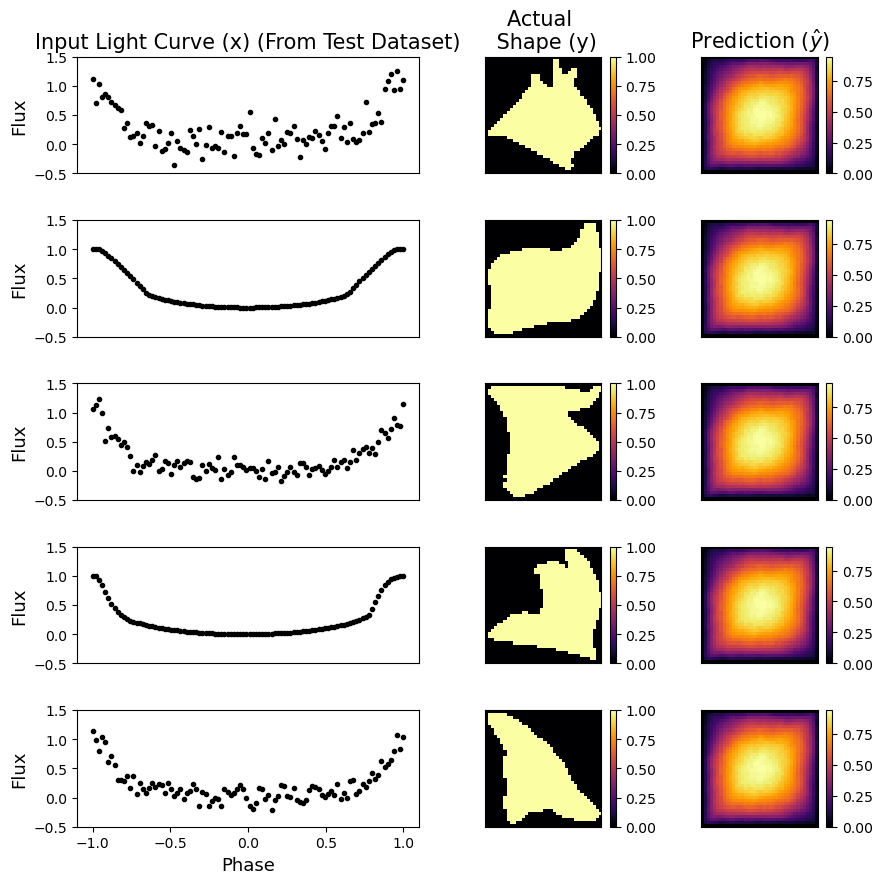

In [117]:
# Test dataset

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x) (From Test Dataset)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTest[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(xTest)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(yTest[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, xTest[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredictonTest[k],cmap='inferno')
    plt.colorbar(img)

In [83]:
yPredicton = model.predict(x_ML)

625/625 [==============================] - 3s 5ms/step


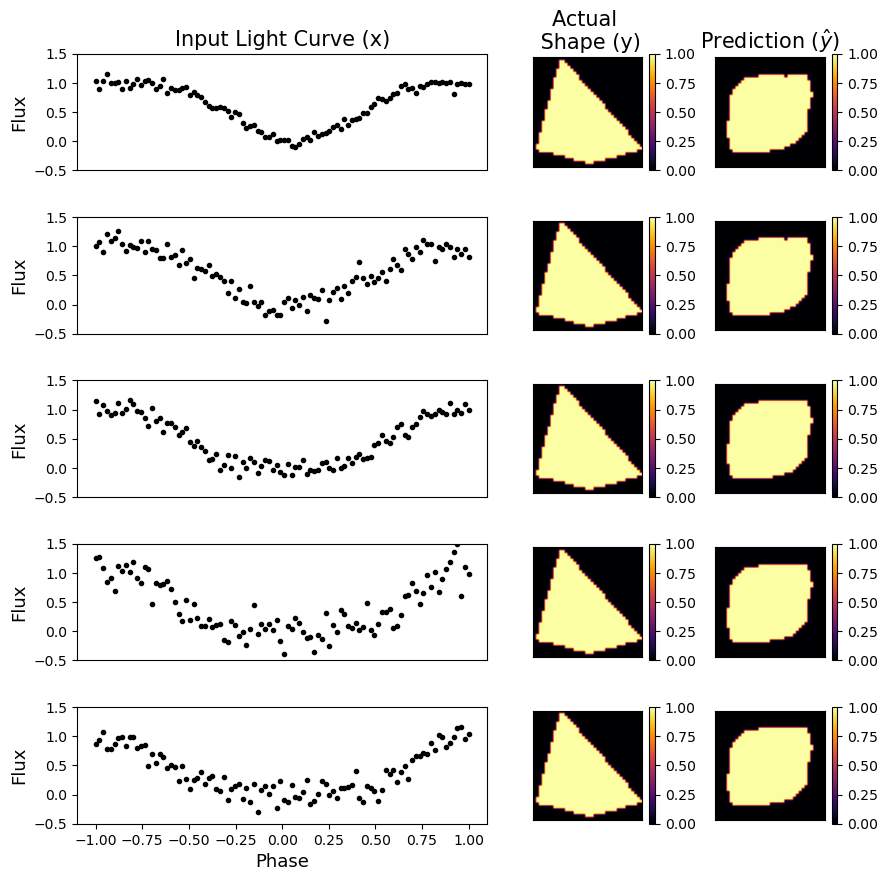

In [114]:
# 0,100,200,300,400

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [3,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTest[0]))
# advance = 60
num_array = [1,1001,2001,3001,4001]
# num_array = [5,1005,2005,3005,4005]
i = 0
for i in np.arange(0,len(num_array)):
    k = num_array[i]
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(y_ML[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, x_ML[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredicton[k],cmap='inferno')
    plt.colorbar(img)
    i = i + 1

In [85]:
yPredicton[yPredicton>=0.5] = 1.
yPredicton[yPredicton<0.5] = 0.

yPredictonTest[yPredictonTest>=0.5] = 1.
yPredictonTest[yPredictonTest<0.5] = 0.

0.19
0.27
0.26
0.29
0.27


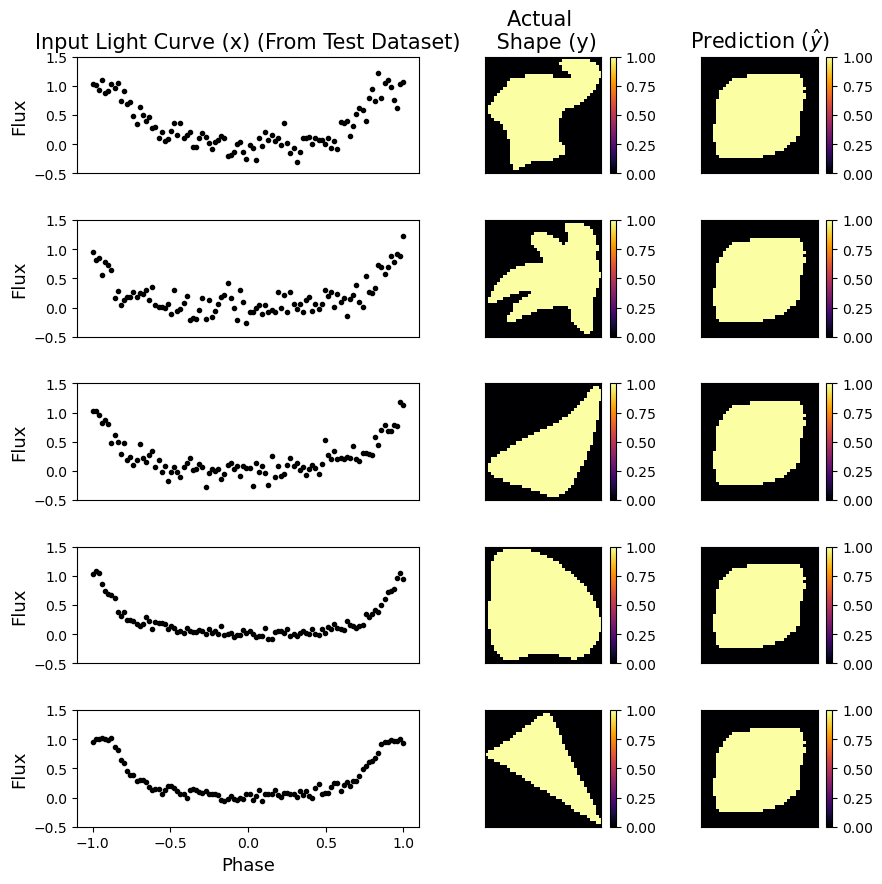

In [86]:
# Test dataset Clipped

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x) (From Test Dataset)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTest[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(xTest)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(yTest[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, xTest[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredictonTest[k],cmap='inferno')
    plt.colorbar(img)
    print(round(np.mean(np.abs(yPredictonTest[k] - yTest[k])),2))

0.21
0.38
0.3
0.21
0.29


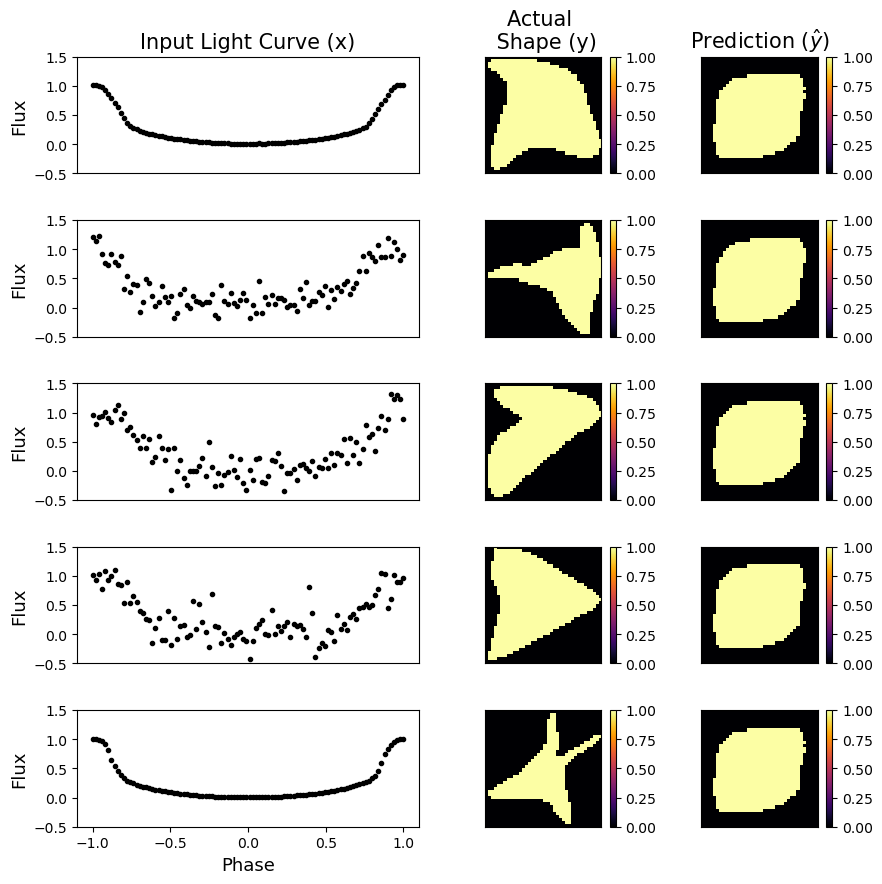

In [87]:

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(x_ML[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(x_ML)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(y_ML[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, x_ML[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredicton[k],cmap='inferno')
    plt.colorbar(img)
    print(round(np.mean(np.abs(yPredicton[k] - y_ML[k])),2))

0.23
0.23
0.23
0.23
0.23


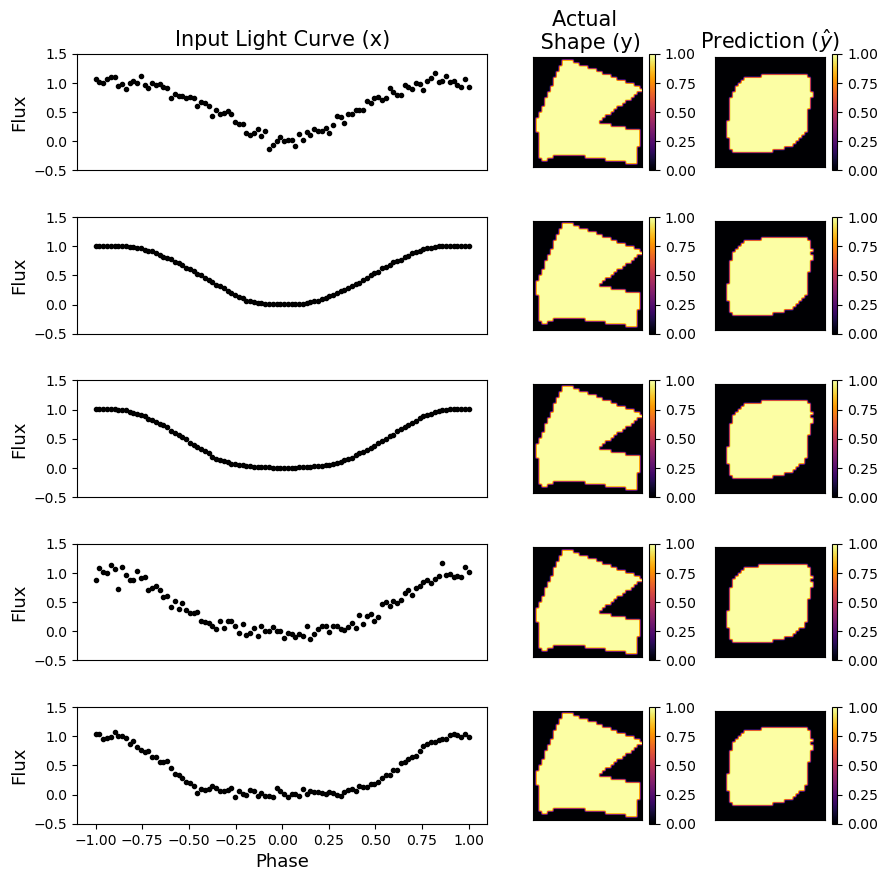

In [88]:
# 0,100,200,300,400

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [3,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(xTest[0]))
# advance = 60
# num_array = [1,1001,2001,3001,4001]
num_array = [5,1005,2005,3005,4005]
i = 0
for i in np.arange(0,len(num_array)):
    k = num_array[i]
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(y_ML[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, x_ML[k],color = 'black',marker='.')
    img = ax[i][2].imshow(yPredicton[k],cmap='inferno')
    plt.colorbar(img)
    i = i + 1
    print(round(np.mean(np.abs(yPredicton[k] - y_ML[k])),2))

In [ ]:
save_model(model, "/home/abraham/Documents/ml_test/ml_saved_models/model_aug7_v1_2000epoch_noise_nofilter_lc.h5")

In [ ]:
model_upload = load_model("/home/abraham/Documents/ml_test/model_aug4_v3_5000epoch_no_noise_normalized_lc.h5")
# summarize model.
model_upload.summary()